In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [2]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [94]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,4)
for lag in lags:
    period = (2000-lag,2004-lag) if not interpolate else (1999-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Cumulative GDP growth
d_gdp_ppp_cum = d_gdp_ppp_lag.sum(axis=1)

# Variances (rolling window, exponential decay)
def calculate_exponentially_weighted_variance(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_index_historical = compute_index_excess_returns(ds, fed, major)
    variances = pd.DataFrame(index=major, columns=panel_dates)
    for i in range(48):
        returns = returns_index_historical.iloc[:,i:i+60]
        means = returns.mean(axis=1)
        returns_demeaned = returns.sub(means, axis=0)
        var_contributions = returns_demeaned**2
        factors = generate_exponential_decay(ratio=ratio)
        vars = var_contributions.mul(factors).sum(axis=1) / sum(factors)
        variances.iloc[:,i] = vars
    variances = variances.stack().rename("variances").astype(float)
    return variances
variances = calculate_exponentially_weighted_variance((1996,2004), panel_dates, 0.9)

In [95]:
from scipy.optimize import minimize_scalar

period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
returns_index_demeaned = returns_index - returns_index.groupby("Country").mean()
returns_index_demeaned_squared = (returns_index_demeaned ** 2)

def compute_r2(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    # model = sm.OLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
    # model = PanelOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa), entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    model = PooledOLS(returns_index_demeaned_squared, sm.add_constant(variances_kappa)).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
    return -model.rsquared


def compute_ss(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    errors = variances_kappa - returns_index_demeaned_squared
    ss = (errors ** 2).to_numpy().sum()
    return ss

kappa_ss = minimize_scalar(compute_ss, bounds=(0,1), method="bounded")
kappa_r2 = minimize_scalar(compute_r2, bounds=(0,1), method="bounded")
print(kappa_r2.x, kappa_ss.x)
print(kappa_r2.fun, kappa_ss.fun)

0.9058656466188171 0.8914021213249128
-0.16591934722811563 0.2678562235517841


In [96]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = PooledOLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

Dep. Variable:,returns,R-squared:,0.3081
Estimator:,PooledOLS,R-squared (Between):,0.9738
No. Observations:,1824,R-squared (Within):,0.0057
Date:,"Wed, Apr 30 2025",R-squared (Overall):,0.3081
Time:,22:20:33,Log-likelihood,5488.3
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,811.70
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(1,1823)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,122.74


In [97]:
variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, 0.9)
model = sm.OLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
fe_model = PanelOLS(returns_index_demeaned_squared, variances_kappa, entity_effects=True).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)
model.summary

from linearmodels.panel import compare

# Estimate both models
re_model = RandomEffects(returns_index_demeaned_squared, variances_kappa).fit(cov_type='kernel', kernel='bartlett', bandwidth=4)

# Hausman test

comparison = hausman(fe_model, re_model)
print(comparison)

(np.float64(5.906802770555258), 1, np.float64(0.015082521769819666))


In [98]:
# Collect dependent and independent variables
scale = True
y = returns_index * (1e2 if scale else 1)
X = pd.concat([
    variances * (1e2 if scale else 1),
    # gdp_cap_ppp / (1e3 if scale else 1),
    d_gdp_ppp_cum * (1e2 if scale else 1),
    returns_world_dummies * (1e2 if scale else 1),
], axis=1)
X = sm.add_constant(X)

In [99]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

Dep. Variable:,returns,R-squared:,0.4430
Estimator:,PanelOLS,R-squared (Between):,-0.1212
No. Observations:,1824,R-squared (Within):,0.4430
Date:,"Wed, Apr 30 2025",R-squared (Overall):,0.4350
Time:,22:20:34,Log-likelihood,-5782.9
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,34.713
Entities:,38,P-value,0.0000
Avg Obs:,48.000,Distribution:,"F(40,1746)"
Min Obs:,48.000,,
Max Obs:,48.000,F-statistic (robust):,4.968e+06


In [93]:
model_panel.params.iloc[4:].mean()

np.float64(1.0471242231231535)

In [9]:
model_panel.total_ss

108764.09501166995

In [39]:
model_panel.resid_ss

60613.84957878611

In [40]:
model_panel.model_ss

48150.24543288384

In [15]:
tss = np.sum((y - y.mean())**2)
tss

np.float64(110327.82314964611)

In [74]:
# Expected world return
period = (1991,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+120]
    mean = returns.mean(axis=1).iloc[0]
    returns_world_expectation[i] = mean

In [132]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = fitted_returns.sum(axis=1).unstack()
(fitted_returns < 0).sum(axis=1)

AR    0
AT    0
BE    0
BR    0
CA    0
CH    0
CL    0
CO    0
CZ    0
DE    0
DK    0
ES    0
FI    0
FR    0
GB    0
GR    0
HK    0
HU    0
ID    0
IL    0
IT    0
JP    0
KR    0
MX    0
MY    0
NL    0
NO    0
PH    0
PL    0
PT    0
RU    0
SE    0
SG    0
TH    0
TR    0
US    0
VE    0
ZA    0
dtype: int64

In [133]:
variances

AR  2001-01-31    0.005594
    2001-02-28    0.009731
    2001-03-31    0.010198
    2001-04-30    0.009204
    2001-05-31    0.008331
                    ...   
ZA  2004-08-31    0.004195
    2004-09-30    0.003764
    2004-10-31    0.003858
    2004-11-30    0.003903
    2004-12-31    0.005121
Name: variances, Length: 1824, dtype: float64

In [134]:
# Covariances
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds / 100
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)

In [135]:
fitted_returns.mean(axis=1)

AR    1.844657
AT    0.663649
BE    0.726464
BR    1.336503
CA    0.575469
CH    0.729386
CL    0.641137
CO    0.898904
CZ    0.837285
DE    0.914007
DK    0.777479
ES    0.552111
FI    1.093175
FR    0.744429
GB    0.590591
GR    0.727168
HK    0.778916
HU    0.712105
ID    1.369787
IL    0.798146
IT    0.802996
JP    0.919241
KR    0.752076
MX    0.807921
MY    0.614436
NL    0.684680
NO    0.763006
PH    0.766169
PL    0.860545
PT    0.714740
RU    0.938555
SE    0.864432
SG    0.633828
TH    1.053673
TR    2.637088
US    0.614503
VE    1.735665
ZA    0.781717
dtype: float64

In [136]:
covs[month]*100

,AR,AT,BE,BR,CA,CH,CL,CO,CZ,DE,...,PL,PT,RU,SE,SG,TH,TR,US,VE,ZA
AR,0.862674,0.094209,0.115436,0.377680,0.163593,0.068393,0.272924,0.257673,0.168423,0.176789,...,0.091007,0.125342,0.220575,0.223084,0.113071,0.266884,0.583208,0.094000,0.258090,0.092253
AT,0.094209,0.219496,0.184967,0.178170,0.102750,0.126401,0.091734,0.221819,0.140337,0.162168,...,0.064654,0.140158,0.042164,0.153456,0.076738,0.117336,0.099583,0.062023,0.072983,0.153719
BE,0.115436,0.184967,0.278601,0.286391,0.141827,0.173735,0.171193,0.254907,0.173252,0.244467,...,0.135355,0.190712,0.107144,0.238295,0.121122,0.147147,0.226828,0.106236,0.113636,0.161380
BR,0.377680,0.178170,0.286391,0.685954,0.250325,0.213072,0.312527,0.314744,0.223801,0.350478,...,0.263953,0.231863,0.226796,0.371455,0.173109,0.276015,0.489685,0.184722,0.127798,0.259154
CA,0.163593,0.102750,0.141827,0.250325,0.189164,0.121142,0.148401,0.169393,0.170511,0.190263,...,0.148134,0.139101,0.164426,0.211602,0.096925,0.165088,0.327689,0.106216,0.155375,0.196578
CH,0.068393,0.126401,0.173735,0.213072,0.121142,0.155065,0.132134,0.175300,0.153133,0.188628,...,0.129523,0.139780,0.103328,0.202606,0.077973,0.132575,0.203800,0.094286,0.073074,0.149481
CL,0.272924,0.091734,0.171193,0.312527,0.148401,0.132134,0.282677,0.186670,0.185833,0.220418,...,0.144377,0.124871,0.168714,0.233576,0.105411,0.202263,0.371806,0.118067,0.177519,0.158142
CO,0.257673,0.221819,0.254907,0.314744,0.169393,0.175300,0.186670,0.665429,0.241266,0.244280,...,0.183113,0.194129,0.239518,0.279401,0.162770,0.189701,0.246519,0.133362,0.314732,0.180289
CZ,0.168423,0.140337,0.173252,0.223801,0.170511,0.153133,0.185833,0.241266,0.506566,0.201524,...,0.227395,0.187709,0.158873,0.251783,0.101739,0.185587,0.444208,0.112647,0.164274,0.203996
DE,0.176789,0.162168,0.244467,0.350478,0.190263,0.188628,0.220418,0.244280,0.201524,0.322466,...,0.194059,0.203214,0.145168,0.326062,0.142238,0.217699,0.397918,0.156421,0.136995,0.181458


In [137]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [138]:
# eta * f
eta_f = (fitted_returns / 100) / cov_risks_diag

In [139]:
cov_risks_diag.mean(axis=1)

AR    0.010273
AT    0.001727
BE    0.002741
BR    0.014030
CA    0.002675
CH    0.002197
CL    0.003297
CO    0.003861
CZ    0.004946
DE    0.004412
DK    0.002922
ES    0.003383
FI    0.010763
FR    0.003822
GB    0.002163
GR    0.006833
HK    0.003922
HU    0.006393
ID    0.014674
IL    0.005865
IT    0.003362
JP    0.003171
KR    0.011573
MX    0.004204
MY    0.004354
NL    0.002963
NO    0.003088
PH    0.006117
PL    0.007508
PT    0.003140
RU    0.013875
SE    0.005745
SG    0.003486
TH    0.011880
TR    0.036525
US    0.002270
VE    0.013414
ZA    0.005122
dtype: float64

In [140]:
pd.DataFrame([fitted_returns.mean(axis=1), cov_risks_diag.mean(axis=1)])

,AR,AT,BE,BR,CA,CH,CL,CO,CZ,DE,...,PL,PT,RU,SE,SG,TH,TR,US,VE,ZA
0,1.844657,0.663649,0.726464,1.336503,0.575469,0.729386,0.641137,0.898904,0.837285,0.914007,...,0.860545,0.71474,0.938555,0.864432,0.633828,1.053673,2.637088,0.614503,1.735665,0.781717
1,0.010273,0.001727,0.002741,0.014030,0.002675,0.002197,0.003297,0.003861,0.004946,0.004412,...,0.007508,0.00314,0.013875,0.005745,0.003486,0.011880,0.036525,0.002270,0.013414,0.005122


In [141]:
eta_f.mean(axis=1)

AR    1.850513
AT    3.978807
BE    2.809052
BR    1.019541
CA    2.467613
CH    3.550225
CL    2.057181
CO    2.463630
CZ    1.871808
DE    2.223146
DK    2.755582
ES    1.729933
FI    1.131275
FR    2.119374
GB    2.853351
GR    1.109657
HK    2.151743
HU    1.211740
ID    0.924740
IL    1.549939
IT    2.602938
JP    2.991199
KR    0.696062
MX    2.348763
MY    1.623941
NL    2.509385
NO    2.520099
PH    1.359294
PL    1.286878
PT    2.421357
RU    0.698268
SE    1.682972
SG    2.257975
TH    0.896519
TR    0.744902
US    3.187787
VE    1.578858
ZA    1.570365
dtype: float64

In [142]:
# # Faster way to calculate costs
# costs_0 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_i == country_j:
#             continue
#         for month in stds.columns:
#             eta_f_i = eta_f.loc[country_i, month]
#             eta_f_j = eta_f.loc[country_j, month]
#             cov_risk_ii = cov_risks.loc[country_i, (month, country_i)]
#             cov_risk_ij = cov_risks.loc[country_i, (month, country_j)]
#             cost_ij = eta_f_i*cov_risk_ii - eta_f_j*cov_risk_ij
#             costs_0.loc[country_i, (month, country_j)] = cost_ij
#     print(country_i, end=" ")
# costs = costs_0
# print("\n")

# # Slower way to calculate costs
# terms = {}
# for country_i in major:
#     weights_i = weights.loc[:, country_i]
#     eta_f_i = eta_f.loc[country_i]
#     terms[country_i] = result = pd.DataFrame(np.outer(weights_i, eta_f_i), index=weights_i.index, columns=eta_f_i.index)

# costs_1 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_j < country_i:
#             continue
#         if country_i == country_j:
#             continue
#         term_diff = terms[country_i] - terms[country_j]
#         for month in stds.columns:
#             # covs_temp = covs.loc[country_i, (month, slice(None))]
#             covs_temp = covs[month].loc[[country_i,country_j]]
#             cost_diff = covs_temp @ term_diff[month]
#             costs_1.loc[country_i, (month, country_j)] = cost_diff.loc[country_i]
#             costs_1.loc[country_j, (month, country_i)] = -cost_diff.loc[country_j]
#     print(country_i, end=" ")
# costs = costs_1
# print("\n")

# Fastest way
costs_9 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs_9[(month, country_i)] = fitted_returns[month] - 100*eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
    print(country_i, end=" ")
costs = costs_9
print("\n")


AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



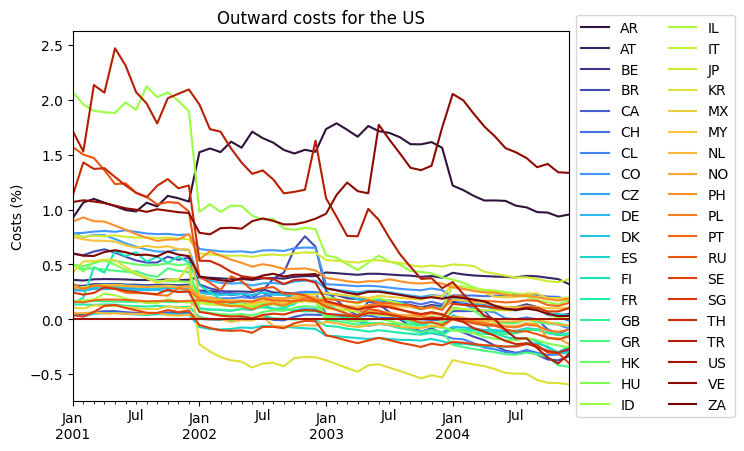

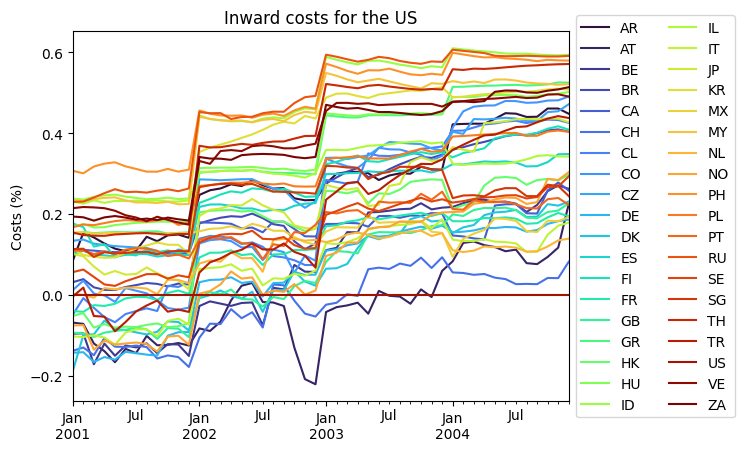

In [143]:
import matplotlib.cm as cm
data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
data_inward = costs.loc["US"].unstack()
color = plt.get_cmap("turbo", 38)
ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.show()

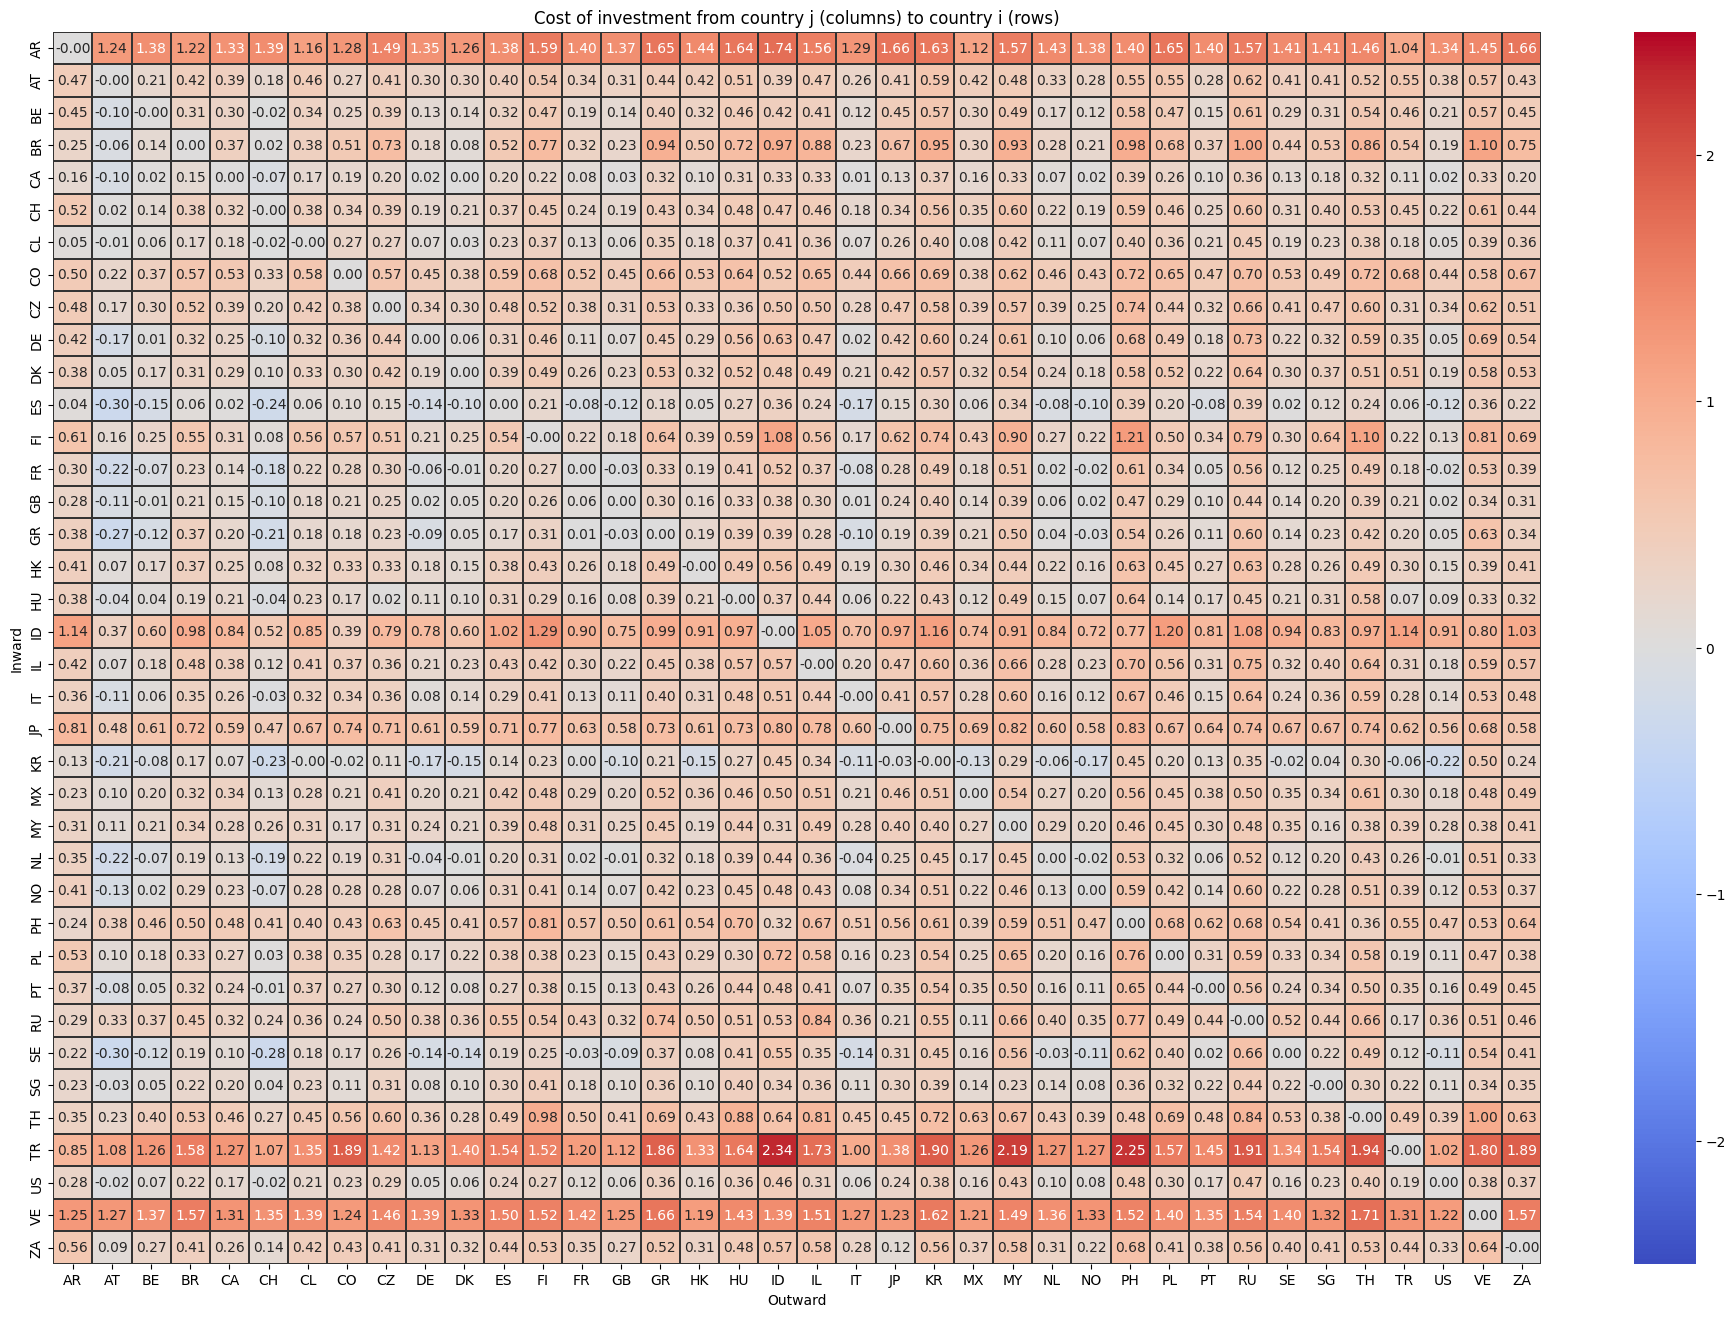

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
costs_mean = costs.T.groupby(level=1).mean().T
costs_mean = costs_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(costs_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

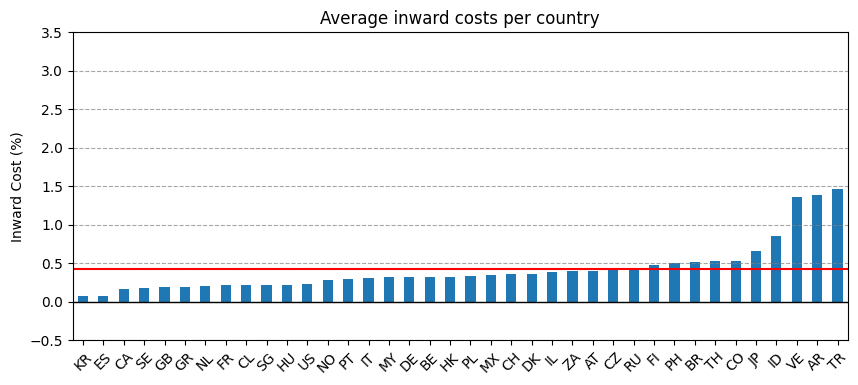

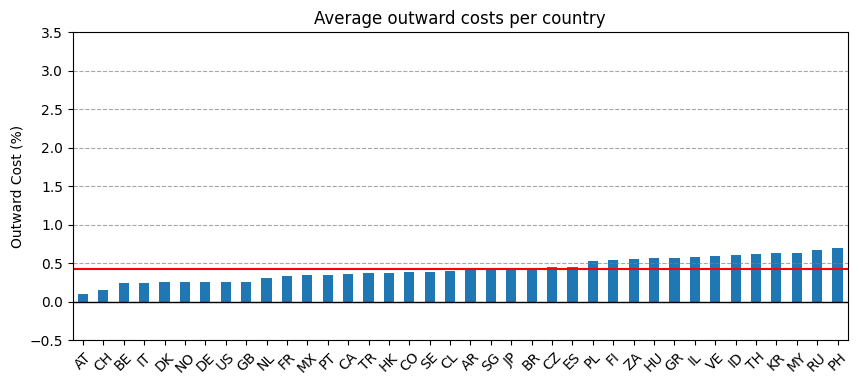

In [145]:
import matplotlib.cm as cm
import matplotlib.colors as colors
color = False
def plot_bar(series, norm, cmap, **params):
    plt.figure(figsize=(10,4))
    bar_colors = cmap(norm(series.values))
    series.plot(kind="bar", color=(bar_colors if color else None), **params)
    plt.axhline(series.mean(), color="red")
    plt.xticks(rotation=45, ha='center')
    plt.axhline(y=0, color="black", linestyle='-', linewidth=1)
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)

def plot_average_costs_per_country(costs_mean, gap=False, ylim=(-0.5,3.5)):
    mean_inward_cost = costs_mean.mean(axis=1).sort_values()
    mean_outward_cost = costs_mean.mean(axis=0).sort_values()
    norm = colors.Normalize(vmin=-4, vmax=4)
    cmap = cm.coolwarm
    if gap:
        plot_bar(mean_inward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average inward cost overstatement per country", ylabel="Inward Cost overstatement (%)", ylim=ylim)
        plot_bar(mean_outward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average outward cost overstatement per country", ylabel="Outward Cost overstatement (%)", ylim=ylim)
    else:
        plot_bar(mean_inward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average inward costs per country", ylabel="Inward Cost (%)", ylim=ylim)
        plot_bar(mean_outward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average outward costs per country", ylabel="Outward Cost (%)", ylim=ylim)
    plt.show()

plot_average_costs_per_country(costs_mean)

In [146]:
print("average over means: ", (costs_mean<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.07409972299168975
average over all obs.:  0.0979772622345337


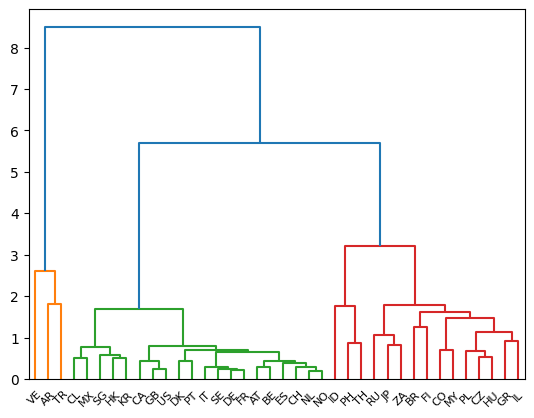

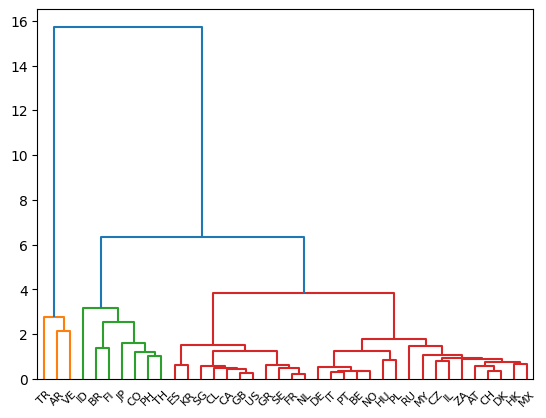

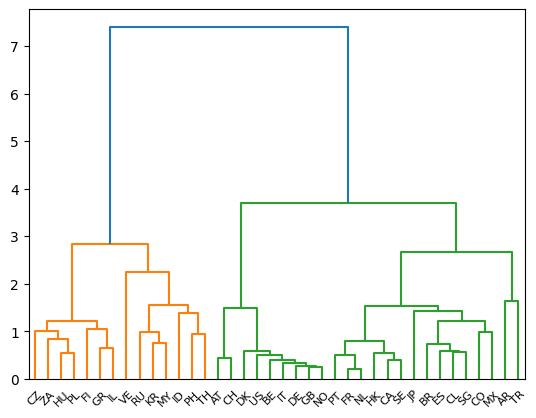

In [147]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Based on average cost between i and j
A = (costs_mean + costs_mean.T)/2 + 1
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on rows = inward costs
A = costs_mean
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on columns = outward costs
A = costs_mean.T
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

In [148]:
cost_gap = pd.DataFrame(0.0, index=costs.index, columns=costs.columns)
for country_i in major: 
    for country_j in major:
        if country_j <= country_i:
            continue            
        for month in stds.columns:
            weights_i = weights[country_i]
            weights_j = weights[country_j]
            cov_i = covs[month].loc[country_i]
            cov_j = covs[month].loc[country_j]
            eta_f_i = eta_f.loc[country_i, month]
            eta_f_j = eta_f.loc[country_j, month]
            weights_diff = (3*(weights_i-weights_j) - (eta_f_i*weights_i - eta_f_j*weights_j))
            cost_gap.loc[country_i, (month, country_j)] =  cov_i @ weights_diff
            cost_gap.loc[country_j, (month, country_i)] =  cov_j @ -weights_diff
    print(country_i, end=" ")
print("\n")

AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



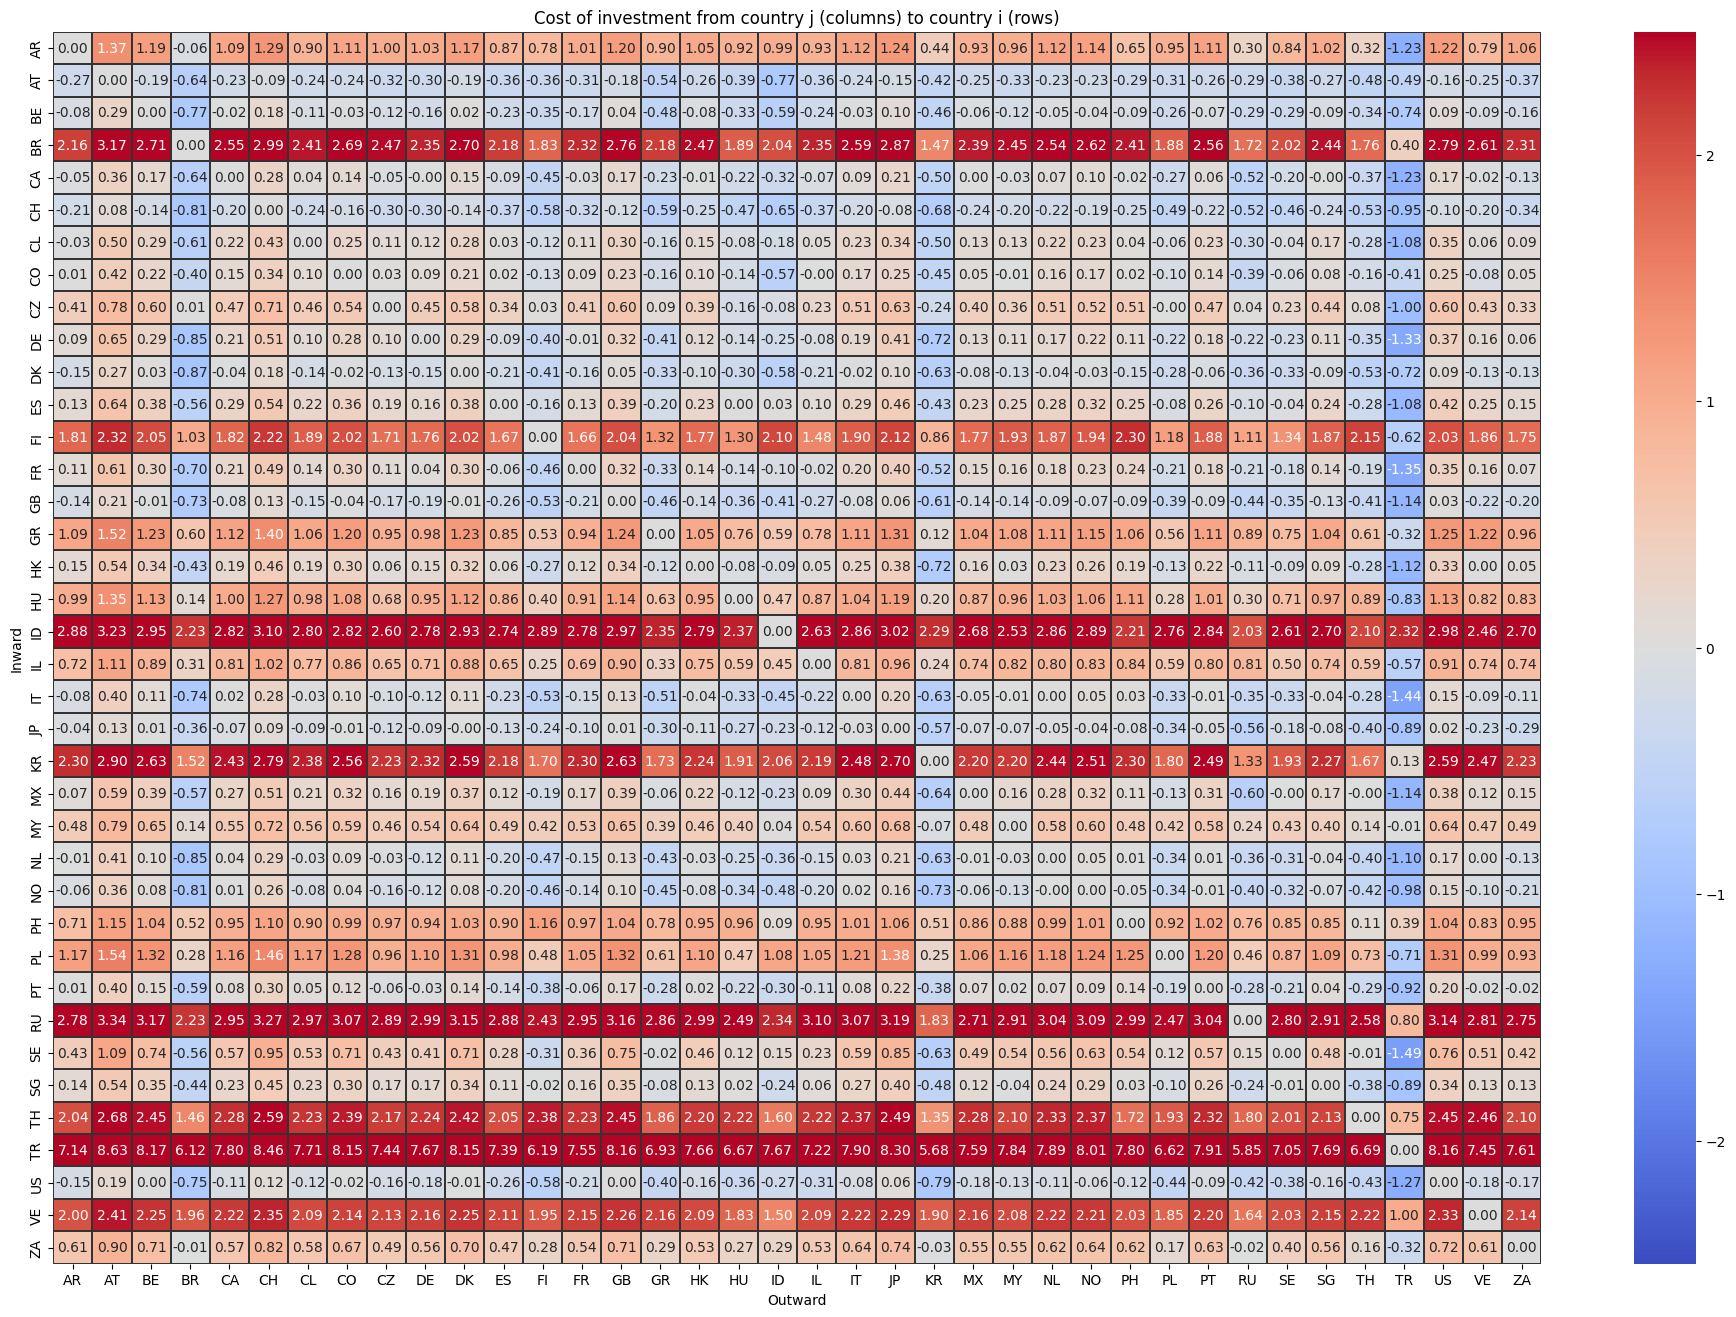

In [149]:
cost_gap_mean = 100*cost_gap.T.groupby(level=1).mean().T
cost_gap_mean = cost_gap_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(cost_gap_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

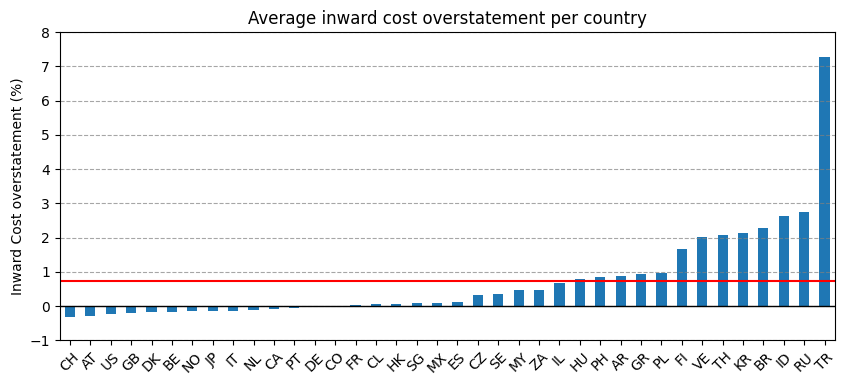

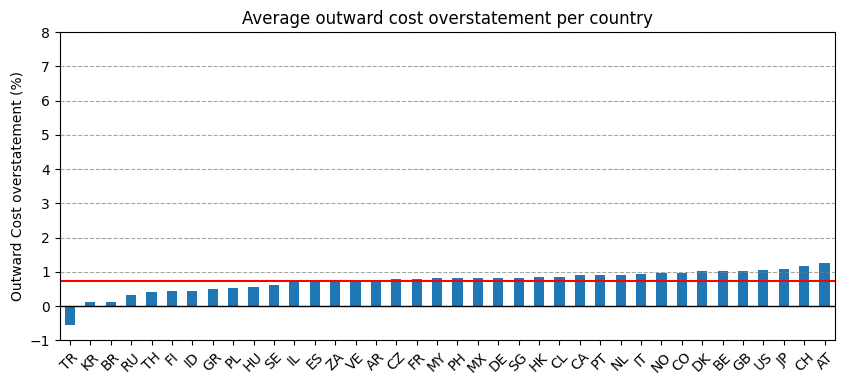

In [150]:
plot_average_costs_per_country(cost_gap_mean, gap=True, ylim=(-1,8))